# Parameter Estimation for Oscillatory model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

2022-11-15 10:03:37.113773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 10:03:37.113787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range: frequency parameter a ~ U(0.1, 1) & shift parameter b ~ N(0, 0.25²)
    freq_samples = np.random.uniform(0.1, 1.0, size=(batch_size, 1))
    shift_samples = np.random.normal(0.0, 0.25, size=(batch_size, 1))
    p_samples = np.c_[freq_samples, shift_samples]
    return p_samples.astype(np.float32)


# Oscillation model        
n_obs = 41  
time_points = np.linspace(0, 10, n_obs)
sigma = 0.05   # noise standard deviation
missing_max = 21

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
# Dataset 1 (n_missing = 15)
param_prior_1 = np.array([[0.2, -0.4]])
result_1 = [np.array([-0.38822525, -0.07585579,  0.09875853,  0.42901483,  0.48185913,
         0.62969871,  0.6457469 ,  0.434365  ,  0.20191629, -0.12380711,
        -0.41445603, -0.71438838, -1.10485856, -1.23079156, -1.36338658,
        -1.44566409, -1.45376767, -1.25233028, -0.98761422, -0.76457333,
        -0.41138701, -0.06165886,  0.19041922,  0.33472721,  0.54920351,
         0.63987353,  0.52822556,  0.4772211 ,  0.0992428 , -0.08048652,
        -0.37974125, -0.6531358 , -1.05218318, -1.23381172, -1.34811474,
        -1.42620643, -1.39496478, -1.15792385, -0.91626909, -0.72581709,
        -0.34380109]),
 np.array([ 0,  1,  2,  3,  4,  5,  6,  9, 11, 13, 14, 16, 17, 19, 20, 24, 25,
        27, 28, 29, 30, 31, 33, 36, 37, 39]),
 np.array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 2.25, 2.75, 3.25, 3.5 ,
        4.  , 4.25, 4.75, 5.  , 6.  , 6.25, 6.75, 7.  , 7.25, 7.5 , 7.75,
        8.25, 9.  , 9.25, 9.75])]

In [6]:
# Dataset 2 (n_missing = 20)
param_prior_2 = np.array([[0.95, 0.1]])
result_2 = [np.array([ 0.0411556 ,  1.08346297,  0.2623786 , -0.92034164, -0.17167728,
         1.02610335,  0.54370587, -0.78445069, -0.52135847,  0.85621658,
         0.77392383, -0.61739495, -0.73033272,  0.55306994,  1.02138007,
        -0.28863467, -0.77016348,  0.38925967,  1.03721564,  0.0408748 ,
        -0.91261586, -0.00819852,  1.12443804,  0.37746972, -0.84010395,
        -0.32655636,  0.99065733,  0.55809712, -0.67683952, -0.53908892,
         0.76198376,  0.88392371, -0.56456167, -0.77304082,  0.58618039,
         0.99736459, -0.13568713, -0.96373333,  0.26542047,  1.05570096,
         0.07219064]),
 np.array([ 1,  4,  5,  7,  9, 12, 14, 15, 16, 19, 21, 22, 24, 26, 27, 28, 32,
        33, 36, 37, 38]),
 np.array([0.25, 1.  , 1.25, 1.75, 2.25, 3.  , 3.5 , 3.75, 4.  , 4.75, 5.25,
        5.5 , 6.  , 6.5 , 6.75, 7.  , 8.  , 8.25, 9.  , 9.25, 9.5 ])]

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_augment01_5ACB_64_64_64_LSTM128_ckpts/ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./Oscillation41_timepoints_5ACB_64_64_64_LSTM128_ckpts/ckpt-300


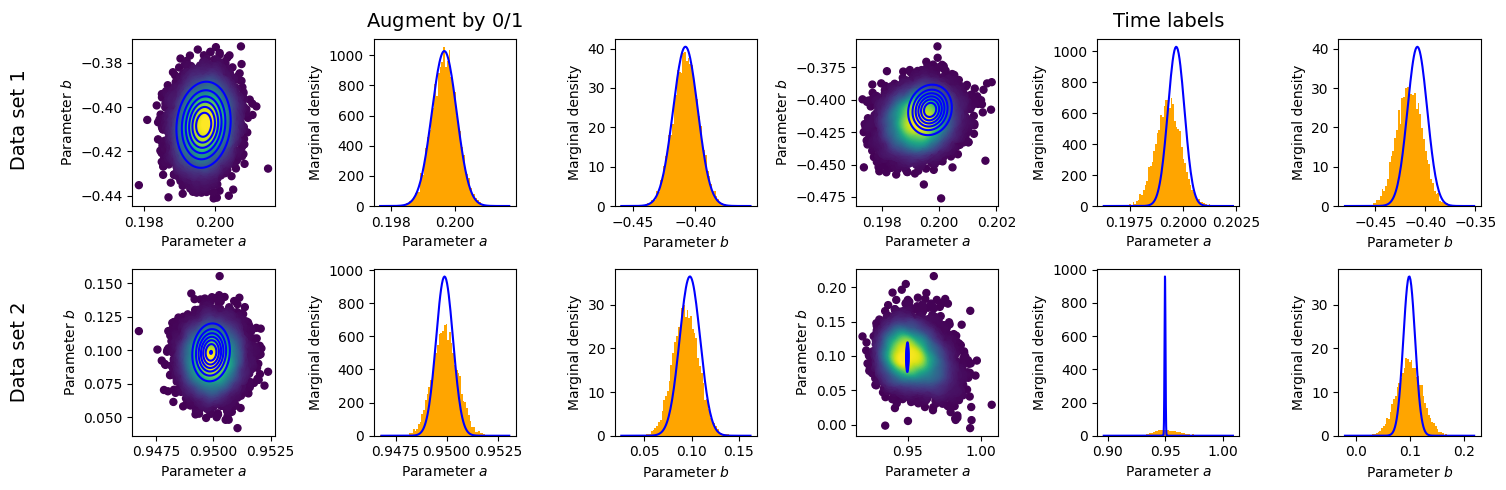

In [10]:
fig, ax = plt.subplots(2, 6, figsize=((15, 5)))
n_post_samples = 7500

# Method 2: Augment 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_augment01_5ACB_64_64_64_LSTM128_ckpts', 
                                     skip_checks=True)

param_prior = param_prior_1
result = result_1
x_data = np.ones((1, n_obs, 2), dtype=np.float32)
x_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
x_data[0][missing_indices] = np.array([-5.0, 0.0])
param_samples_1 = amortizer.sample(x_data, n_post_samples)
plot_posterior(ax, 0, 0, result, param_samples_1, 'Augment by $0/1$')

param_prior = param_prior_2
result = result_2
x_data = np.ones((1, n_obs, 2), dtype=np.float32)
x_data[0, :, 0] = result[0]
missing_indices = np.setdiff1d(range(n_obs), result[1])
x_data[0][missing_indices] = np.array([-5.0, 0.0])
param_samples_2 = amortizer.sample(x_data, n_post_samples)
plot_posterior(ax, 1, 0, result, param_samples_2, 'Augment by $0/1$')


# Method 3: Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./Oscillation41_timepoints_5ACB_64_64_64_LSTM128_ckpts', 
                                     skip_checks=True)

param_prior = param_prior_1
result = result_1
n_present = len(result[1])
x_data = np.ones((1, n_present, 2), dtype=np.float32)
x_data[0, :, 0] = result[0][result[1]]
x_data[0, :, 1] = result[2]
param_samples_3 = amortizer.sample(x_data, n_post_samples)
plot_posterior(ax, 0, 1, result, param_samples_3, 'Time labels')

param_prior = param_prior_2
result = result_2
n_present = len(result[1])
x_data = np.ones((1, n_present, 2), dtype=np.float32)
x_data[0, :, 0] = result[0][result[1]]
x_data[0, :, 1] = result[2]
param_samples_4 = amortizer.sample(x_data, n_post_samples)
plot_posterior(ax, 1, 1, result, param_samples_4, 'Time labels')

fig.supylabel('   Data set 2                     Data set 1', fontsize=14, x=-0.0005)                      
plt.tight_layout()
plt.show()
#fig.savefig("figures/Osc_augment_time.png", dpi=300, bbox_inches='tight') 
#fig.savefig("figures/Osc_augment_time.pdf", bbox_inches='tight') 